# Simulated Dataset 1: Spatial Patterns of Varying Complexity

## Loading package

In [ ]:
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
## filter out all warnings
warnings.filterwarnings('ignore')

np.random.seed(2024)

## the location of R (used for the mclust clustering)
## need to be replaced with the installation path of R
os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'
from sklearn.metrics.cluster import adjusted_rand_score
from utils_ours import mclust_R
from preprocess import clr_normalize_each_cell

## Loading data

In [ ]:
# the location of Human_Lymph_Node Dataset
# need to be replaced
file_fold_1 = './Human_Lymph_Node_A1/adata_RNA'
file_fold_2 = './Human_Lymph_Node_A1/adata_ADT'

adata_omics_1_1 = sc.read_h5ad(file_fold_1 + '.h5ad')
adata_omics_1_2 = sc.read_h5ad(file_fold_2 + '.h5ad')

## Annotation of A1 scice
Ann_df = pd.read_csv('./Human_Lymph_Node/annotation.txt', sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata_omics_1_1.obs['Ground Truth'] = Ann_df.loc[adata_omics_1_1.obs_names, 'Ground Truth']
adata_omics_1_2.obs['Ground Truth'] = Ann_df.loc[adata_omics_1_2.obs_names, 'Ground Truth']

## Pre-processing data

In [ ]:
adata_omics_1_1.var_names_make_unique()
adata_omics_1_2.var_names_make_unique()

# RNA
sc.pp.filter_genes(adata_omics_1_1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics_1_1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics_1_1, target_sum=1e4)
sc.pp.log1p(adata_omics_1_1)
sc.pp.scale(adata_omics_1_1)
adata_omics_1_1 =  adata_omics_1_1[:, adata_omics_1_1.var['highly_variable']]

# Protein
adata_omics_1_2 = clr_normalize_each_cell(adata_omics_1_2)
sc.pp.scale(adata_omics_1_2)

ground_truth_counts = adata_omics_1_1.obs['Ground Truth'].value_counts()
print(ground_truth_counts)

Ground Truth
medulla cords                  1188
medulla sinuses                 797
cortex                          753
pericapsular adipose tissue     320
capsule                         204
subcapsular sinus                74
follicle                         60
medulla vessels                  57
hilum                            23
trabeculae                        8
Name: count, dtype: int64


## Real data selection
The selected cell types included medulla cords, medulla sinuses, cortex, and pericapsular adipose tissue, representing the maximum number of spots.

In [ ]:
# Select the four categories with the lagest number
categories = ['medulla cords', 'medulla sinuses', 'cortex', 'pericapsular adipose tissue']

adata_omics_1_1 = adata_omics_1_1[adata_omics_1_1.obs['Ground Truth'].isin(categories)]
adata_omics_1_2 = adata_omics_1_2[adata_omics_1_2.obs['Ground Truth'].isin(categories)]

def random_sample_per_category(adata, categories, sample_size=300):
    # An empty AnnData object is initialized to store the final samples
    sampled_adata = None
    
    # Iterate over each category
    for category in categories:
        category_idx = adata.obs['Ground Truth'] == category
        
        # sample_size samples are randomly selected
        if category_idx.sum() > sample_size:
            indices = np.random.choice(category_idx[category_idx].index, size=sample_size, replace=False)
        else:
            indices = category_idx[category_idx].index

        category_data = adata[indices]

        if sampled_adata is None:
            sampled_adata = category_data
        else:
            sampled_adata = sampled_adata.concatenate([category_data], join='outer', index_unique='-')
    
    return sampled_adata

adata_omics_1_1 = random_sample_per_category(adata_omics_1_1, categories, 300)
adata_omics_1_2 = random_sample_per_category(adata_omics_1_2, categories, 300)

original_to_new_labels = {
    "medulla cords": 'a',
    "medulla sinuses": 'b',
    "cortex": 'c',
    "pericapsular adipose tissue": 'd'
}

categories_order = [
    'a', 'b', 'c', 'd'
]

adata_omics_1_1.obs['Ground Truth'] = adata_omics_1_1.obs['Ground Truth'].map(original_to_new_labels)
adata_omics_1_2.obs['Ground Truth'] = adata_omics_1_2.obs['Ground Truth'].map(original_to_new_labels)

adata_omics_1_1.obs['Ground Truth'] = pd.Categorical(adata_omics_1_1.obs['Ground Truth'],categories=categories_order, ordered=True)
adata_omics_1_2.obs['Ground Truth'] = pd.Categorical(adata_omics_1_2.obs['Ground Truth'],categories=categories_order, ordered=True)

## Randomly split into 3 batches
batch = [1 + (i % 3) for i in range(1200)]
adata_omics_1_1.obs['batch'] = batch
adata_omics_1_2.obs['batch'] = batch

## Spatial coordinates generation
Four spatial distribution patterns were generated by assigning spatial coordinates to 300 spots per cell type.

1. Quadrant Pattern: a simple spatial distribution with well-separated regions

In [ ]:
x_values = np.linspace(0, 60, 20, endpoint=False)
y_values = np.linspace(0, 60, 20, endpoint=False)

## Initialize the coordinates
coordinates = np.zeros((20 * 20, 2), dtype=int)

## Fill coordinates
for i in range(20):
    for j in range(20):
        coordinates[i * 20 + j, 0] = x_values[j]
        coordinates[i * 20 + j, 1] = y_values[i]
coordinates = np.repeat(coordinates, 3, axis=0)

## Split points
x_split = 30
y_split = 30
## Create the coordinates of the four regions
quadrant1 = coordinates[(coordinates[:, 0] < x_split) & (coordinates[:, 1] < y_split)]
quadrant2 = coordinates[(coordinates[:, 0] >= x_split) & (coordinates[:, 1] < y_split)]
quadrant3 = coordinates[(coordinates[:, 0] < x_split) & (coordinates[:, 1] >= y_split)]
quadrant4 = coordinates[(coordinates[:, 0] >= x_split) & (coordinates[:, 1] >= y_split)]

# Merge the coordinates of the four regions
all_coordinates = np.vstack((quadrant1, quadrant2, quadrant3, quadrant4))
adata_omics_1_1.obsm['spatial'] = all_coordinates
adata_omics_1_2.obsm['spatial'] = all_coordinates

2. Stripe Pattern: a moderate spatial complexity with gradual transitions between regions, forming stripe-like patterns

In [ ]:
x_values = np.linspace(0, 60, 20, endpoint=False)
y_values = np.linspace(0, 60, 20, endpoint=False)

# Initialize the coordinates
coordinates = np.zeros((20 * 20, 2), dtype=int)

# Fill coordinates
for i in range(20):
    for j in range(20):
        coordinates[i * 20 + j, 0] = x_values[j]
        coordinates[i * 20 + j, 1] = y_values[i]
coordinates = np.repeat(coordinates, 3, axis=0)
adata_omics_1_1.obsm['spatial'] = coordinates
adata_omics_1_2.obsm['spatial'] = coordinates

3. Arc Pattern: a more intricate spatial pattern with gradual transitions between regions, exhibiting curved patterns

In [ ]:
x_values = np.linspace(0, 60, 20, endpoint=False)
y_values = np.linspace(0, 60, 20, endpoint=False)

# 初始化坐标数组
coordinates = np.zeros((20 * 20, 2), dtype=int)

# 填充坐标数组
for i in range(20):
    for j in range(20):
        coordinates[i * 20 + j, 0] = x_values[j]
        coordinates[i * 20 + j, 1] = y_values[i]

# 计算每个点与点（28.5,28.5）之间的距离
distances = np.sqrt((coordinates[:, 0] - 0) ** 2 + (coordinates[:, 1] - 0) ** 2)

# 根据距离对坐标数组进行排序
# argsort()函数返回的是数组值从小到大的索引值
sorted_indices = np.argsort(distances)
sorted_coordinates = coordinates[sorted_indices]

sorted_coordinates = np.repeat(sorted_coordinates, 3, axis=0)

adata_omics_1_1.obsm['spatial'] = sorted_coordinates
adata_omics_1_2.obsm['spatial'] = sorted_coordinates

4. Layered Pattern: the most complex spatial structure, characterized by concentric, progressively changing regions

In [ ]:
x_values = np.linspace(0, 60, 20, endpoint=False)
y_values = np.linspace(0, 60, 20, endpoint=False)

# 初始化坐标数组
coordinates = np.zeros((20 * 20, 2), dtype=int)

# 填充坐标数组
for i in range(20):
    for j in range(20):
        coordinates[i * 20 + j, 0] = x_values[j]
        coordinates[i * 20 + j, 1] = y_values[i]

# 计算每个点与点（28.5,28.5）之间的距离
distances = np.sqrt((coordinates[:, 0] - 28.5) ** 2 + (coordinates[:, 1] - 28.5) ** 2)

# 根据距离对坐标数组进行排序
# argsort()函数返回的是数组值从小到大的索引值
sorted_indices = np.argsort(distances)
sorted_coordinates = coordinates[sorted_indices]

sorted_coordinates = np.repeat(sorted_coordinates, 3, axis=0)

adata_omics_1_1.obsm['spatial'] = sorted_coordinates
adata_omics_1_2.obsm['spatial'] = sorted_coordinates

## Visualize of real expression data and selected cell types

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


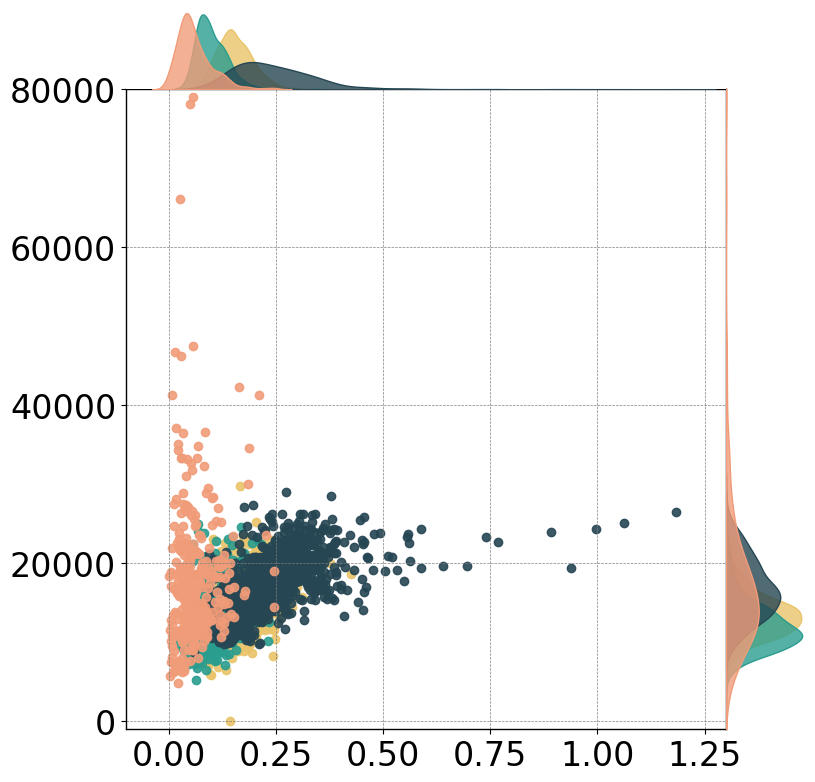

In [ ]:
file_fold_1 = 'D:/study/learning/spatial_transcriptome/codes/SpatialGlue-main/data/Dataset11_Human_Lymph_Node_A1/adata_RNA'
file_fold_2 = 'D:/study/learning/spatial_transcriptome/codes/SpatialGlue-main/data/Dataset11_Human_Lymph_Node_A1/adata_ADT'

adata_omics_1_1 = sc.read_h5ad(file_fold_1 + '.h5ad')
adata_omics_1_2 = sc.read_h5ad(file_fold_2 + '.h5ad')

Ann_df = pd.read_csv('D:/study/learning/spatial_transcriptome/codes/SpatialGlue-main/data/ours/4_Human_Lymph_Node/annotation.txt', sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata_omics_1_1.obs['Ground Truth'] = Ann_df.loc[adata_omics_1_1.obs_names, 'Ground Truth']
adata_omics_1_2.obs['Ground Truth'] = Ann_df.loc[adata_omics_1_2.obs_names, 'Ground Truth']

categories = ['medulla cords', 'medulla sinuses', 'cortex', 'pericapsular adipose tissue']

adata_omics_1_1 = adata_omics_1_1[adata_omics_1_1.obs['Ground Truth'].isin(categories)]
adata_omics_1_2 = adata_omics_1_2[adata_omics_1_2.obs['Ground Truth'].isin(categories)]

# Convert the data format and calculate the average
RNA = adata_omics_1_1.X.toarray()
protein = adata_omics_1_2.X.toarray()
RNA = np.average(RNA, axis=1)
protein = np.average(protein, axis=1)

colors = [
    '#e9c46a', '#2a9d8f', '#264653', '#f19c79'
]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.15, 0.1, 0.75, 0.8])   # Scatter plot location
ax1 = fig.add_axes([0.15, 0.9, 0.75, 0.1])  # Marginal distribution map location 1
ax2 = fig.add_axes([0.9, 0.1, 0.1, 0.8])    # Marginal distribution map location 2

# Scatter plot
for i, category in enumerate(categories):
    idx = adata_omics_1_1.obs['Ground Truth'] == category
    ax.scatter(RNA[idx], protein[idx], label=category, alpha=0.9, color=colors[i])
ax.set_xlim([-0.1, 1.3])
ax.set_ylim([-1000, 80000])
ticks = np.arange(0, 80001, 20000)
ax.set_yticks(ticks)
ax.tick_params(axis='both', labelsize=24)

for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_color('black')

ax.grid(True, linestyle='--', color='gray', linewidth=0.5)

# Marginal distribution map - RNA
for i, category in enumerate(categories):
    idx = adata_omics_1_1.obs['Ground Truth'] == category
    sns.kdeplot(RNA[idx], ax=ax1, vertical=False, color=colors[i], bw_adjust=1, fill=colors[i], alpha=0.8)
ax1.set_ylabel('')
ax1.set_xlim([-0.1, 1.3])
ax1.set_xticks([])
ax1.set_yticks([])
for spine in ax1.spines.values():
        spine.set_visible(False)

# Marginal distribution map - Protein
for i, category in enumerate(categories):
    idx = adata_omics_1_1.obs['Ground Truth'] == category
    sns.kdeplot(protein[idx], ax=ax2, color=colors[i], bw_adjust=1, fill=colors[i], alpha=0.8, vertical=True)
ax2.set_xlabel('')
ax2.set_ylim([-0.1, 80000])
ax2.set_xticks([])
ax2.set_yticks([])
for spine in ax2.spines.values():
        spine.set_visible(False)

ax.set_title('')
ax.set_xlabel('', fontsize=28, fontname='Arial')
ax.set_ylabel('', fontsize=28, fontname='Arial')

# save
plt.tight_layout()
plt.savefig('./expression.png')
plt.savefig('./expression.eps')
plt.show()